# Quantum Volume

In [2]:
from qiskit_experiments.library import QuantumVolume
from qiskit_experiments.framework import BatchExperiment
from qiskit import transpile, execute
from qiskit.circuit.library import QuantumVolume as QuantumVolumeCircuit
from qiskit.quantum_info import Statevector

from huayi_providers.fake_huayi37 import FakeHuayi37, FakeHuayi37V2
from huayi_providers.fake_QuantinuumH2 import FakeQuantinuumh2, FakeQuantinuumh2V2
from qiskit_ionq import IonQProvider
from qiskit.providers.fake_provider import *
from qiskit_aer.noise.noise_model import NoiseModel

from qiskit import Aer
from qiskit_aer import AerSimulator

import pandas as pd

## Use qiskit-experiments built-in QV measurement

**Error message**

Don't use V1 backend (including FakeHuayi12, FakeMontreal, ...)

something wrong with:

``transpiled_circuits = experiment._transpiled_circuits()``


There is also an unknown problem when n_qubits or trials is too big when use V2 backend

some discussions:

https://github.com/Qiskit-Extensions/qiskit-experiments/issues/846


In [ ]:
def collect_data(batch_data):
    results_table = pd.DataFrame()
    for i in range(batch_data.num_experiments):
        qv_result = batch_data.child_data(i).analysis_results("quantum_volume")
        data = {'QV': qv_result.value} | {'quality': qv_result.quality} | qv_result.extra
        results_table = pd.concat([results_table, pd.DataFrame(data, index=[i])], ignore_index=True)
    return results_table

In [ ]:
simulator_huayi = FakeHuayi37V2()
simulator_montreal = FakeMontrealV2()

# Each QuantumVolume() is an Experimet class
# The length of tuple() is the circuit depth
exps = [QuantumVolume(tuple(range(i)), trials=100) for i in range(3,7)]

# Batch the experiments (with different depth) into one object
batch_exp = BatchExperiment(exps)
batch_exp.set_transpile_options(optimization_level=3)

# Run with the specified backend
data_huayi = batch_exp.run(simulator_huayi).block_for_results()
data_montreal = batch_exp.run(simulator_montreal).block_for_results()

# Collect the results in the 'results_table'
results_huayi = collect_data(data_huayi)
results_montreal = collect_data(data_montreal)

# results_table = pd.DataFrame()
# for i in range(batch_exp.num_experiments):
#     qv_result = data_huayi.child_data(i).analysis_results("quantum_volume")
#     data = {'QV': qv_result.value} | {'quality': qv_result.quality} | qv_result.extra
#     results_table = pd.concat([results_table, pd.DataFrame(data, index=[i])], ignore_index=True)

display(results_huayi)
display(data_huayi.child_data(batch_exp.num_experiments-1).figure(0))

display(results_montreal)
display(data_montreal.child_data(batch_exp.num_experiments-1).figure(0))

In [ ]:
# Single run

# Each QuantumVolume() is an Experimet class
# The length of tuple() is the circuit depth
exps = QuantumVolume(tuple(range(4)), trials=160) 

# Batch the experiments (with different depth) into one object
exps.set_transpile_options(optimization_level=3)

backend = AerSimulator.from_backend(FakeMontrealV2())
# Run with the specified backend
expdata = exps.run(backend).block_for_results()

expdata.figure(0)

## From qiskit textbook

https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/measuring-quantum-volume.ipynb

Procedure:

1. Set ``ncircuits`` and ``nshots``, sweep ``depth``
2. Generate ``ncircuits`` random circuits
3. For each ``circuit``, simulate heavy-ouput, w/o and w/ noise. The noisy simulations are averaged over ``nshots`` times

In [ ]:
def get_heavy_outputs(counts):
    """Extract heavy outputs from counts dict.
    Args:
        counts (dict): Output of `.get_counts()`
    Returns:
        list: All states with measurement probability greater
              than the mean.
    """
    # sort the keys of `counts` by value of counts.get(key)
    sorted_counts = sorted(counts.keys(), key=counts.get)
    # discard results with probability < median
    heavy_outputs = sorted_counts[len(sorted_counts)//2:]
    return heavy_outputs

def check_threshold(nheavies, ncircuits, nshots):
    """Evaluate adjusted threshold inequality for quantum volume.
    Args:
        nheavies (int): Total number of heavy outputs measured from device
        ncircuits (int): Number of different square circuits run on device
        nshots (int): Number of shots per circuit
    Returns:
        Bool:
            True if heavy output probability is > 2/3 with 97% certainty,
            otherwise False
    """
    from numpy import sqrt
    numerator = nheavies - 2*sqrt(nheavies*(nshots-(nheavies/ncircuits)))
    return bool(numerator/(ncircuits*nshots) > 2/3)


def test_qv(device, nqubits, ncircuits, nshots):
    """Try to achieve 2**nqubits quantum volume on device.
    Args:
        device (qiskit.providers.Backend): Device to test.
        nqubits (int): Number of qubits to use for test.
        ncircuits (int): Number of different circuits to run on the device.
        nshots (int): Number of shots per circuit.
    Returns:
        Bool
            True if device passes test, otherwise False.
    """
    from numpy import sqrt

    def get_ideal_probabilities(circuit):
        """Simulates circuit behaviour on a device with no errors."""
        state_vector = Statevector.from_instruction(
                circuit.remove_final_measurements(inplace=False)
            )
        return state_vector.probabilities_dict()

    def get_real_counts(circuit, backend, shots):
        """Runs circuit on device and returns counts dict."""
        t_circuit = transpile(circuit, backend, optimization_level=3)
        job = backend.run(t_circuit,
                          shots=shots,
                          memory=True)
        return job.result().get_counts(), t_circuit

    # generate set of random circuits
    qv_circuits = [
        QuantumVolumeCircuit(nqubits) for c in range(ncircuits)
    ]

    nheavies = [0]*ncircuits  # number of measured heavy outputs
    cum_HOP = [0]*ncircuits  # cumulant heavy-output percentage
    cum_2sigma = [0]*ncircuits  # cumulant 2-sigma deviation
    transpiled_circuits = []
    for i, circuit in enumerate(qv_circuits):
        # simulate circuit
        ideal_heavy_outputs = get_heavy_outputs(
            get_ideal_probabilities(circuit)
        )
        # run circuit on device
        circuit.measure_all()
        real_counts, t_circuit = get_real_counts(circuit, device, nshots)
        transpiled_circuits.append(t_circuit)
        # record whether device result is in the heavy outputs
        for output, count in real_counts.items():
            if output in ideal_heavy_outputs:
                nheavies[i] += count
        cum_HOP[i] = sum(nheavies[0:i+1]) / nshots / (i+1)
        cum_2sigma[i] = 2 * sqrt( cum_HOP[i] * ( 1 - cum_HOP[i] ) / (i+1) )

    # do statistical check to see if device passes test
    is_pass = check_threshold(sum(nheavies), ncircuits, nshots)
    # calculate percentage of measurements that are heavy outputs
    percent_heavy_outputs = sum(nheavies)*100/(ncircuits*nshots)

    results = {
        "backend":device.name(),
        "n_qubits":nqubits,
        "QV": 2**nqubits, 
        "HOP": percent_heavy_outputs, 
        "success": is_pass, 
        "n_circuits": ncircuits,
        "n_shots": nshots,
        "cum_HOP":cum_HOP,
        "cum_2sigma":cum_2sigma}

    print(f"Quantum Volume: {2**nqubits}\n"
          f"Percentage Heavy Outputs: {percent_heavy_outputs:.1f}%\n"
          f"Passed?: {is_pass}\n")
    return results, qv_circuits, transpiled_circuits


In [ ]:
ncircuits = 100
nshots = 10

result, qv_circs, tr_circs = test_qv(FakeQuantinuumh2(), 6, ncircuits=ncircuits, nshots=nshots)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.scatter(range(ncircuits), result["cum_HOP"], s=6, c='r')
ax.fill_between(range(ncircuits), 
                np.array(result["cum_HOP"]) - np.array(result["cum_2sigma"]), 
                np.array(result["cum_HOP"]) + np.array(result["cum_2sigma"]), color='b', alpha=0.4)
ax.hlines(2/3, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='k')
ax.set_ylim([0.5,1])


In [ ]:
import os
import json
import pandas as pd

if not os.path.isdir("./QV_test"):
    os.mkdir("./QV_test")

ncircuits = 200
nshots = 20

results_huayi = pd.DataFrame()
results_quantinuum = pd.DataFrame()

for depth in range(1,11):

    result, qv_circs, tr_circs = test_qv(FakeQuantinuumh2(), depth, ncircuits=ncircuits, nshots=nshots)
    results_quantinuum = pd.concat([result, pd.DataFrame(result, columns=["backend", "n_qubits", "QV", "HOP", "success", "n_circuits", "n_shots"], index=[0])], ignore_index=True)
    qv_export = result | {"QV_circuits": [c.qasm() for c in qv_circs]} | {"transpiled_circuits": [c.qasm() for c in tr_circs]}
    
    with open("QV_test/QV_FakeQuantinuumh2_{}.json".format(depth), 'w') as f:
        json.dump(qv_export, f)



for depth in range(1,11):

    result, qv_circs, tr_circs = test_qv(FakeHuayi37(), depth, ncircuits=ncircuits, nshots=nshots)
    results_huayi = pd.concat([result, pd.DataFrame(result, columns=["backend", "n_qubits", "QV", "HOP", "success", "n_circuits", "n_shots"], index=[0])], ignore_index=True)
    qv_export = result | {"QV_circuits": [c.qasm() for c in qv_circs]} | {"transpiled_circuits": [c.qasm() for c in tr_circs]}
    
    with open("QV_test/QV_FakeHuayi37_{}.json".format(depth), 'w') as f:
        json.dump(qv_export, f)

In [13]:
qv_circ = QuantumVolumeCircuit(4)
qv_circ.measure_all()
tr_circ = transpile(qv_circ, FakeHuayi37(), optimization_level=3)

display(qv_circ.decompose().draw(fold=200))
display(tr_circ.draw(fold=200, idle_wires=False))

┌──────────┐            ┌──────────┐            ┌──────────┐┌──────────┐ ░ ┌─┐         
   q_0: ────────────┤0         ├────────────┤1         ├────────────┤1         ├┤1         ├─░─┤M├─────────
        ┌──────────┐│          │┌──────────┐│          │┌──────────┐│          ││  su4_254 │ ░ └╥┘┌─┐      
   q_1: ┤1         ├┤          ├┤0         ├┤          ├┤0         ├┤          ├┤0         ├─░──╫─┤M├──────
        │  su4_544 ││  su4_116 ││  su4_778 ││  su4_365 ││  su4_378 ││  su4_782 │├──────────┤ ░  ║ └╥┘┌─┐   
   q_2: ┤0         ├┤          ├┤1         ├┤          ├┤1         ├┤          ├┤0         ├─░──╫──╫─┤M├───
        └──────────┘│          │└──────────┘│          │└──────────┘│          ││  su4_967 │ ░  ║  ║ └╥┘┌─┐
   q_3: ────────────┤1         ├────────────┤0         ├────────────┤0         ├┤1         ├─░──╫──╫──╫─┤M├
                    └──────────┘            └──────────┘            └──────────┘└──────────┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                0  1  2  3

global phase: 4.8225
           ┌────────────┐ ┌────────────┐ ┌────────────┐    ┌────────────┐┌─────────┐     ┌─────────┐  ┌──────────┐               ┌────────────┐ ┌────────────┐┌─────────────┐       ┌────────────┐»
q_1 -> 24 ─┤ Rx(2.8071) ├─┤ Ry(2.2009) ├─┤ Rx(1.1654) ├─■──┤ Rx(2.7219) ├┤ Ry(π/2) ├─■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■──┤ Rx(1.4398) ├─┤ Ry(1.1264) ├┤ Rx(-1.4728) ├────■──┤ Rx(3.0432) ├»
           ├────────────┤ ├────────────┤ ├───────────┬┘ │ ┌┴────────────┤└─────────┘ │ ┌─┴─────────┴─┐├─────────┬┘┌─────────┐ │ ┌┴────────────┤ ├────────────┤├─────────────┤    │  ├────────────┤»
q_2 -> 25 ─┤ Rx(2.4167) ├─┤ Ry(1.5808) ├─┤ Rx(-1.38) ├──■─┤ Rx(0.62465) ├────────────■─┤ Rx(-2.1067) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■─┤ Rx(-2.8932) ├─┤ Ry(1.2878) ├┤ Rx(0.83767) ├─■──┼──┤ Rx(2.3776) ├»
           ├────────────┤┌┴────────────┤┌┴───────────┴┐   └┬────────────┤┌─────────┐   └─┬─────────┬─┘├─────────┴┐└─────────┘   ├─────────────┤ └┬──────────┬┘├─────────────┤ │  │ ┌┴────────────┤»
q_3 -> 26 ─┤ Rx(2.9074) ├┤ Ry(0.88096) ├┤ Rx(-1.8059) ├─■──┤ Rx(2.5747) ├┤ Ry(π/2) ├─■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■─┤ Rx(0.46408) ├──┤ Ry(2.05) ├─┤ Rx(-1.3719) ├─■──┼─┤ Rx(0.28425) ├»
          ┌┴────────────┤└┬────────────┤├─────────────┤ │ ┌┴────────────┤└─────────┘ │ ┌─┴─────────┴─┐├─────────┬┘┌─────────┐ │ ├─────────────┴┐┌┴──────────┴┐└┬───────────┬┘    │ └─┬──────────┬┘»
q_0 -> 27 ┤ Rx(-1.4174) ├─┤ Ry(1.0027) ├┤ Rx(-3.0225) ├─■─┤ Rx(0.48722) ├────────────■─┤ Rx(-1.5408) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■─┤ Rx(-0.57586) ├┤ Ry(1.4554) ├─┤ Rx(1.924) ├─────■───┤ Rx(1.03) ├─»
          └─────────────┘ └────────────┘└─────────────┘   └─────────────┘              └─────────────┘└─────────┘ └─────────┘   └──────────────┘└────────────┘ └───────────┘         └──────────┘ »
  meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
                                                                                                                                                                                                  »
«          ┌─────────┐        ┌─────────┐  ┌──────────┐                 ┌──────────────┐ ┌────────────┐  ┌────────────┐  ░    ┌─┐      
«q_1 -> 24 ┤ Ry(π/2) ├────■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├───────────────■─┤ Rx(-0.70996) ├─┤ Ry(2.1338) ├──┤ Rx(2.3961) ├──░────┤M├──────
«          ├─────────┤    │   ├─────────┤  ├──────────┤               │ ├─────────────┬┘ ├────────────┤┌─┴────────────┴┐ ░    └╥┘┌─┐   
«q_2 -> 25 ┤ Ry(π/2) ├─■──┼───┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■──┼─┤ Rx(0.41955) ├──┤ Ry(2.3693) ├┤ Rx(-0.074909) ├─░─────╫─┤M├───
«          └─────────┘ │  │ ┌─┴─────────┴─┐├─────────┬┘┌─────────┐ │  │ ├─────────────┤ ┌┴────────────┤└┬─────────────┬┘ ░     ║ └╥┘┌─┐
«q_3 -> 26 ────────────■──┼─┤ Rx(-1.5406) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■──┼─┤ Rx(-1.5104) ├─┤ Ry(0.96145) ├─┤ Rx(0.92334) ├──░─────╫──╫─┤M├
«                         │ ├─────────────┤├─────────┤ ├─────────┤    │ ├─────────────┤ └┬────────────┤ └┬────────────┤  ░ ┌─┐ ║  ║ └╥┘
«q_0 -> 27 ───────────────■─┤ Rx(-1.5791) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├────■─┤ Rx(0.13384) ├──┤ Ry(2.9858) ├──┤ Rx(1.3982) ├──░─┤M├─╫──╫──╫─
«                           └─────────────┘└─────────┘ └─────────┘      └─────────────┘  └────────────┘  └────────────┘  ░ └╥┘ ║  ║  ║ 
«  meas: 4/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
«                                                                                                                           0  1  2  3

In [11]:
job = FakeHuayi37().run(tr_circ, shots=100, memory=True)
job.result().get_counts()

{'001111': 1,
 '100110': 4,
 '110001': 1,
 '101111': 3,
 '000110': 4,
 '100100': 2,
 '001101': 2,
 '000011': 1,
 '110100': 3,
 '101100': 3,
 '001011': 4,
 '100010': 4,
 '111110': 3,
 '101010': 1,
 '000001': 2,
 '110110': 3,
 '110010': 1,
 '000101': 1,
 '101110': 2,
 '001110': 3,
 '111011': 2,
 '100101': 1,
 '000100': 1,
 '101101': 1,
 '100011': 1,
 '001100': 3,
 '111101': 5,
 '110000': 1,
 '000111': 2,
 '011010': 4,
 '010111': 2,
 '011011': 1,
 '011000': 1,
 '110111': 2,
 '000000': 1,
 '010000': 3,
 '011001': 1,
 '000010': 1,
 '101011': 1,
 '011100': 2,
 '010110': 1,
 '101001': 2,
 '010100': 1,
 '001000': 2,
 '001001': 2,
 '100000': 2,
 '111111': 2,
 '100111': 1,
 '011101': 1,
 '011111': 1,
 '010001': 1}

q_0: ─■────
      │    
q_1: ─┼──■─
      │  │ 
q_2: ─┼──■─
      │    
q_3: ─■────

q_0: ─■─
      │ 
q_1: ─■─
        
q_2: ─■─
      │ 
q_3: ─■─

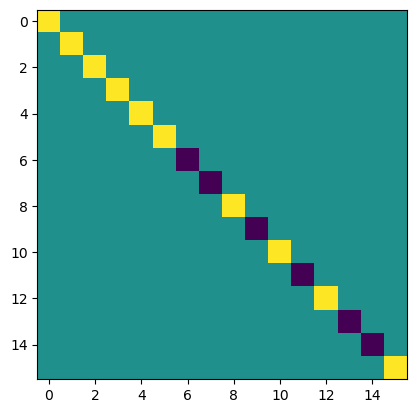

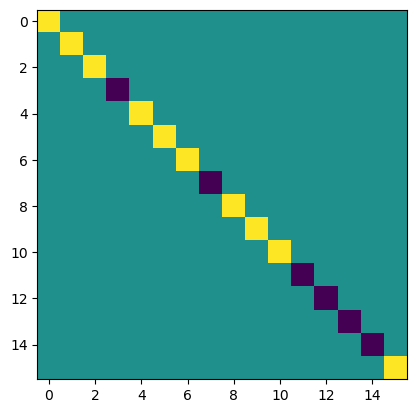

In [30]:
from qiskit import QuantumRegister
from qiskit import QuantumCircuit, execute
from qiskit import Aer
import numpy as np
import matplotlib.pyplot as plt


q = QuantumRegister(4,'q')

c1 = QuantumCircuit(q)
c1.cz(q[0],q[3])
c1.cz(q[1],q[2])
job = execute(c1, Aer.get_backend('unitary_simulator'), shots=1)
M1 = job.result().get_unitary(c1,2).data


c2 = QuantumCircuit(q)
# c2.cz(q[1],q[2])
c2.cz(q[0],q[1])
c2.cz(q[2],q[3])
# c2.cz(q[1],q[2])
job = execute(c2, Aer.get_backend('unitary_simulator'), shots=1)
M2 = job.result().get_unitary(c2,2).data

display(c1.draw())
fig, ax = plt.subplots()
im = ax.imshow(np.real( M1 ))


display(c2.draw())
fig, ax = plt.subplots()
im = ax.imshow(np.real( M2 ))


In [105]:
# c1: ideal circuit (no noise, fully connected)
# c2: nearest-neighbour circuit, 1qb_err = 0.01%, N.N_err = 0.1% (within N.N.)
# c3: next-nearest-neighbour circuit, 1qb_err = 0.01%, N.N_err = 0.1%, N.N.N._err increases

c1 = QuantumCircuit(q)
c1.cz(q[1],q[2])
c1.x(q[1])
c1.cz(q[0],q[1])
c1.sx(q[1])
c1.cz(q[1],q[2])
c1.sx(q[2])
c1.cz(q[2],q[3])
c1.x(q[3])
c1.x(q[0])
c1.cz(q[3],q[0])

c1.measure_all()

state_vector = Statevector.from_instruction(
    c1.remove_final_measurements(inplace=False) )
ideal_prob = state_vector.probabilities_dict()

display(ideal_prob)


basis_gates = ['x','sx','rz','cz']
cmap2 = [[0,1],[1,0],[1,2],[2,1],[2,3],[3,2]]
cmap3 = [[0,1],[0,2],[1,0],[1,2],[1,3],[2,0],[2,1],[2,3],[3,1],[3,2]]

c2 = transpile(c1, coupling_map=[[0,1],[1,0],[1,2],[2,1],[2,3],[3,2]],basis_gates=['x','sx','rz','cz'], optimization_level=3)
c3 = transpile(c1, coupling_map=[[0,1],[0,2],[1,0],[1,2],[1,3],[2,0],[2,1],[2,3],[3,1],[3,2]],basis_gates=['x','sx','rz','cz'], optimization_level=3)

display(c1.draw())
display(c2.draw(fold=-1))
display(c3.draw(fold=-1))

{'1001': 0.25, '1011': 0.25, '1101': 0.25, '1111': 0.25}

┌───┐                      ░ ┌─┐         
   q_0: ─────────■─┤ X ├───────────────────■──░─┤M├─────────
           ┌───┐ │ ├───┴┐                  │  ░ └╥┘┌─┐      
   q_1: ─■─┤ X ├─■─┤ √X ├─■────────────────┼──░──╫─┤M├──────
         │ └───┘   └────┘ │ ┌────┐         │  ░  ║ └╥┘┌─┐   
   q_2: ─■────────────────■─┤ √X ├─■───────┼──░──╫──╫─┤M├───
                            └────┘ │ ┌───┐ │  ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────────────────■─┤ X ├─■──░──╫──╫──╫─┤M├
                                     └───┘    ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                 0  1  2  3

┌─────────────┐┌────┐                                           ┌────────┐  ┌────┐    ┌────┐┌─────────────┐                                   ░    ┌─┐      
q_2 -> 0 ─■─┤ Rz(-1.8613) ├┤ √X ├─────────────────────────────────────■─────┤ Rz(-π) ├──┤ √X ├──■─┤ √X ├┤ Rz(-1.5635) ├───────────────────────────────────░────┤M├──────
          │ └────┬───┬────┘└────┘   ┌────┐  ┌─────────────┐┌────┐     │     └─┬────┬─┘┌─┴────┴┐ │ ├────┤└┬────────────┤┌────┐                             ░    └╥┘┌─┐   
q_1 -> 1 ─■──────┤ X ├───────■──────┤ √X ├──┤ Rz(-1.5781) ├┤ √X ├─────■───────┤ √X ├──┤ Rz(π) ├─■─┤ √X ├─┤ Rz(1.8613) ├┤ √X ├──────────────────■──────────░─────╫─┤M├───
                 └───┘       │   ┌──┴────┴─┐└────┬────┬───┘└────┘   ┌────┐  ┌─┴────┴┐ └───────┘   ├────┤ └─┬───────┬──┘└────┘┌────┐┌─────────┐ │ ┌───┐    ░     ║ └╥┘┌─┐
q_0 -> 2 ────────────────────■───┤ Rz(π/2) ├─────┤ √X ├──────■──────┤ √X ├──┤ Rz(π) ├───────────■─┤ √X ├───┤ Rz(π) ├─────■───┤ √X ├┤ Rz(π/2) ├─■─┤ X ├─■──░─────╫──╫─┤M├
                                 └─────────┘     └────┘      │   ┌──┴────┴─┐└─┬────┬┘ ┌───────┐ │ ├────┤  ┌┴───────┴┐    │   └────┘└─────────┘   └───┘ │  ░ ┌─┐ ║  ║ └╥┘
q_3 -> 3 ────────────────────────────────────────────────────■───┤ Rz(π/2) ├──┤ √X ├──┤ Rz(π) ├─■─┤ √X ├──┤ Rz(π/2) ├────■─────────────────────────────■──░─┤M├─╫──╫──╫─
                                                                 └─────────┘  └────┘  └───────┘   └────┘  └─────────┘                                     ░ └╥┘ ║  ║  ║ 
 meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                             0  1  2  3

┌────┐            ░       ┌─┐   
q_2 -> 0 ─■────────────────■─┤ √X ├─■──────────░───────┤M├───
          │                │ └────┘ │ ┌───┐    ░       └╥┘┌─┐
q_3 -> 1 ─┼────────────────┼────────■─┤ X ├─■──░────────╫─┤M├
          │ ┌───┐   ┌────┐ │          └───┘ │  ░    ┌─┐ ║ └╥┘
q_1 -> 2 ─■─┤ X ├─■─┤ √X ├─■────────────────┼──░────┤M├─╫──╫─
            └───┘ │ ├───┬┘                  │  ░ ┌─┐└╥┘ ║  ║ 
q_0 -> 3 ─────────■─┤ X ├───────────────────■──░─┤M├─╫──╫──╫─
                    └───┘                      ░ └╥┘ ║  ║  ║ 
 meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                  0  1  2  3

In [121]:

from qiskit_aer.aerprovider import AerProvider, QasmSimulator,AerSimulator

import qiskit_aer.noise as noise


basis_gates = ['x','sx','rz','cz']
cmap2 = [[0,1],[1,0],[1,2],[2,1],[2,3],[3,2]]
cmap3 = [[0,1],[0,2],[1,0],[1,2],[1,3],[2,0],[2,1],[2,3],[3,1],[3,2]]


# Error probabilities
prob_1 = 0.0005  # 1-qubit gate
prob_2 = 0.005   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
error_3 = noise.depolarizing_error(10*prob_2, 2)

# Add errors to noise model
noise_model2 = noise.NoiseModel()
noise_model2.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
noise_model2.add_all_qubit_quantum_error(error_2, ['cz'])

be2 = AerSimulator(basis_gates = basis_gates, n_qubits=4,
                   noise_model=noise_model2, coupling_map=cmap2)


noise_model3 = noise.NoiseModel()
noise_model3.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
for qubits in cmap3:
    if qubits not in cmap2:
        noise_model3.add_quantum_error(error_2, ['cz'], qubits)
    else:
        noise_model3.add_quantum_error(error_3, ['cz'], qubits)

be3 = AerSimulator(basis_gates = basis_gates, n_qubits=4,
                   noise_model=noise_model3, coupling_map=cmap3)

counts2 = be2.run(transpile(c2, backend=be2), shots=10000).result().get_counts()
counts3 = be3.run(transpile(c3, backend=be3), shots=10000).result().get_counts()

display(ideal_prob)
display(counts2)
display(counts3)

{'1001': 0.25, '1011': 0.25, '1101': 0.25, '1111': 0.25}

{'1011': 2390,
 '0100': 15,
 '1101': 2378,
 '1001': 2457,
 '0110': 9,
 '1111': 2560,
 '0111': 24,
 '1110': 24,
 '0011': 10,
 '0000': 21,
 '1010': 25,
 '0010': 15,
 '1100': 20,
 '0101': 22,
 '0001': 18,
 '1000': 12}

{'1011': 2452,
 '1101': 2350,
 '1111': 2396,
 '0001': 68,
 '1001': 2275,
 '1110': 47,
 '0101': 52,
 '1100': 73,
 '1010': 59,
 '0011': 70,
 '1000': 79,
 '0111': 61,
 '0000': 5,
 '0100': 6,
 '0010': 4,
 '0110': 3}